# Financial Transactions 

Data Source: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets/data

This data source has five data files: 
- cards_data.csv
- transactions_data.csv
- users_data.csv
- mcc_codes.json
- train_fraud_labels.json

The objective of this project is to understand common characteristics of fraudulent transactions.

Maybe:
predictive model to accurately identify potentially fraudulent transactions in real time


## Step 1: Load Data

### Loading Data

In [4]:
#Import libraries 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import json
import seaborn as sns
from tabulate import tabulate

# Load all csv files into Pandas DataFrame
cards_df = pd.read_csv("cards_data.csv") 
trans_df = pd.read_csv("transactions_data.csv")
users_df = pd.read_csv("users_data.csv")

# Loading merchant category codes as pandas DataFrame
with open('mcc_codes.json', 'r') as file:
    mcc_data = json.load(file)  # Load the JSON data into a Python object

mcc_data_list =[]
for key, value in mcc_data.items():
    entry = {"mcc" : key, "Name": value}
    mcc_data_list.append(entry)

# Normalize the loaded JSON data into a DataFrame
mcc_df = pd.DataFrame(mcc_data_list)

## Load fraud labels as pandas DataFrame
with open('train_fraud_labels.json', 'r') as file:
    tfl_data = json.load(file)  # Load the JSON data into a Python object

tfl_data_list =[]
for key, value in tfl_data['target'].items():
    entry = {"id" : key, "fraud": value}
    tfl_data_list.append(entry)

# Normalize the loaded JSON data into a DataFrame
tfl_df = pd.DataFrame(tfl_data_list)

In [5]:
print("\n Transaction data ---------------------------------------")
print(trans_df.shape)
print(trans_df.dtypes)
print("\n Cards data ----------------------------------------------")
print(cards_df.shape)
print(cards_df.dtypes)
print("\n Users data ---------------------------------------------")
print(users_df.shape)
print(users_df.dtypes)
print("\n Merchant category code data ----------------------------")
print(mcc_df.shape)
print(mcc_df.dtypes)
print("\n Transaction fraud labels data --------------------------")
print(tfl_df.shape)
print(tfl_df.dtypes)


 Transaction data ---------------------------------------
(13305915, 12)
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

 Cards data ----------------------------------------------
(6146, 13)
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

 Users data ---------------------------------------------
(2000, 14)
id                     int64


## Step 2: Data Cleansing

In [7]:
## Convert objects to int64, floats, or dates
# transaction data
trans_df['date'] = pd.to_datetime(trans_df['date'])
trans_df['amount'] = trans_df['amount'].replace({r'[^\d.-]': ''}, regex=True)
trans_df['amount'] = trans_df['amount'].astype(float)

# card data
cards_df['has_chip_binary'] = cards_df['has_chip'].map({'YES': 1, 'NO': 0})
cards_df['expires'] = pd.to_datetime(cards_df['expires'], format='%m/%d/%Y', errors='coerce')
cards_df['acct_open_date'] = pd.to_datetime(cards_df['acct_open_date'], format='%m/%d/%Y', errors='coerce')
cards_df['credit_limit'] = cards_df['credit_limit'].replace({r'[^\d.-]': ''}, regex=True)
cards_df['credit_limit'] = cards_df['credit_limit'].astype(float)
cards_df['card_on_dark_web'] = cards_df['card_on_dark_web'].map({'YES': 1, 'NO': 0})

# user data
users_df['gender_binary'] = users_df['gender'].map({'Male': 1, 'Female': 0})

users_df['per_capita_income'] = users_df['per_capita_income'].replace({r'[^\d.-]': ''}, regex=True)
users_df['per_capita_income'] = users_df['per_capita_income'].astype(float)

users_df['yearly_income'] = users_df['yearly_income'].replace({r'[^\d.-]': ''}, regex=True)
users_df['yearly_income'] = users_df['yearly_income'].astype(float)

users_df['total_debt'] = users_df['total_debt'].replace({r'[^\d.-]': ''}, regex=True)
users_df['total_debt'] = users_df['total_debt'].astype(float)

# merchant data and fraud label cata
mcc_df['mcc'] = mcc_df['mcc'].astype(int)
tfl_df['id'] = tfl_df['id'].astype(int)



### Merge Datasets

In [9]:
# Merge transaction data with fraud label data
trans_fraud = pd.merge(trans_df, tfl_df, on = "id", how = "inner")
trans_fraud['fraud_binary'] = trans_fraud['fraud'].map({'Yes': 1, 'No': 0})

# Merge merchant information with transaction data (tfm = transaction, fraud, merchant) 
tfm = pd.merge(trans_fraud, mcc_df, on = "mcc", how = "left")
# Merge card information with users dataframe
card_user = pd.merge(cards_df, users_df, left_on = "client_id", right_on = "id", how = "left", suffixes=("_cards", "_users"))
# Combined transaction, fraud, merchant, card, user info
tfmcu = pd.merge(tfm, card_user, left_on = "card_id", right_on = "id_cards", how = "left")


### Converting categorical columns to binary 


In [11]:
categorical_columns = ['use_chip', 'card_brand', 'card_type']

# Create the dummy columns without dropping the original columns
tfmcu_dummies = pd.get_dummies(tfmcu[categorical_columns], prefix=categorical_columns, drop_first=False)

# Concatenate the original DataFrame with the dummy columns
tfmcu = pd.concat([tfmcu, tfmcu_dummies], axis=1)

### Engineering new categories from available data

In [13]:
# Replace zeros in denominator columns with NaN
# Replace zeros in denominator columns with NaN without inplace
tfmcu["credit_limit"] = tfmcu["credit_limit"].replace(0, np.nan)
tfmcu["total_debt"] = tfmcu["total_debt"].replace(0, np.nan)
tfmcu["credit_score"] = tfmcu["credit_score"].replace(0, np.nan)
tfmcu["per_capita_income"] = tfmcu["per_capita_income"].replace(0, np.nan)

## Selecting, transforming, and creating relevant input variables (features) from raw data
tfmcu["ratio_amount_to_credit_limit"] = tfmcu["amount"] / tfmcu["credit_limit"]
tfmcu["ratio_amount_to_total_debt"] = tfmcu["amount"] / tfmcu["total_debt"]
tfmcu["ratio_amount_to_credit_score"] = tfmcu["amount"] / tfmcu["credit_score"]
tfmcu["ratio_credit_limit_to_total_debt"] = tfmcu["credit_limit"] / tfmcu["total_debt"]
tfmcu["ratio_income_to_capita_income"] = tfmcu["yearly_income"] / tfmcu["per_capita_income"]

tfmcu.head(5)
tfmcu.columns

Index(['id', 'date', 'client_id_x', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'fraud', 'fraud_binary', 'Name', 'id_cards', 'client_id_y',
       'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip',
       'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'has_chip_binary',
       'id_users', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'gender_binary', 'use_chip_Chip Transaction',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction',
       'card_brand_Amex', 'card_brand_Discover', 'card_brand_Mastercard',
       'card_brand_Visa', 'card_type_Credit', 'card_type_Debit',
       'card_type_Debit (Prepaid)', 'ratio_amount_to_credit_limit',
       'ratio_a

### Data Profile - Summary Statistics

In [15]:
# Create a subset of the data 
tfmcu_sub = tfmcu[['amount',
       'fraud_binary', 'has_chip_binary',
       'num_cards_issued', 'credit_limit',
       'year_pin_last_changed', 'current_age',
       'retirement_age', 'gender_binary', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards',
       'ratio_amount_to_credit_limit', 'ratio_amount_to_total_debt',
       'ratio_amount_to_credit_score', 'ratio_credit_limit_to_total_debt',
       'ratio_income_to_capita_income',  'use_chip_Chip Transaction', 'use_chip_Online Transaction',
       'use_chip_Swipe Transaction', 'card_brand_Amex', 'card_brand_Discover',
       'card_brand_Mastercard', 'card_brand_Visa', 'card_type_Credit',
       'card_type_Debit', 'card_type_Debit (Prepaid)'
       ]]

#Summary Statistics 
summary_statistics = tfmcu_sub.describe().T
styled_table = summary_statistics.style.format(precision=2).set_table_styles(
    [
        {'selector': 'thead th', 'props': [('background-color', '#f0f0f0'), ('color', '#333'), ('font-weight', 'bold')]},
        {'selector': 'tbody td', 'props': [('border', '1px solid #ddd')]}
    ]
)
styled_table


,count,mean,std,min,25%,50%,75%,max
amount,8914963.00,42.95,81.53,-500.00,8.93,28.99,63.68,6613.44
fraud_binary,8914963.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
has_chip_binary,8914963.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
num_cards_issued,8914963.00,1.52,0.52,1.00,1.00,2.00,2.00,3.00
credit_limit,8879274.00,15612.09,12166.41,1.00,8200.00,13500.00,20859.00,141391.00
year_pin_last_changed,8914963.00,2011.34,2.89,2002.00,2010.00,2011.00,2013.00,2020.00
current_age,8914963.00,54.02,15.72,23.00,42.00,52.00,63.00,101.00
retirement_age,8914963.00,66.49,3.59,53.00,65.00,66.00,68.00,79.00
gender_binary,8914963.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
per_capita_income,8865163.00,24118.30,11872.92,8155.00,17161.00,21178.00,27474.00,163145.00


In [16]:
# Export to Excel
tfmcu.to_csv('output.csv', index=False)

## Step 3: Exploratory Data Analysis (EDA)

### Percent of Fraudulent Activities

In [19]:
print("Total number of fraudulent transactions is ", tfmcu["fraud_binary"].sum() , '.')
print(f"The percent of fraudulent transactions is {tfmcu["fraud_binary"].mean() *100:.2f}%")

Total number of fraudulent transactions is  13332 .
The percent of fraudulent transactions is 0.15%


### Fraudulent Activities over Time

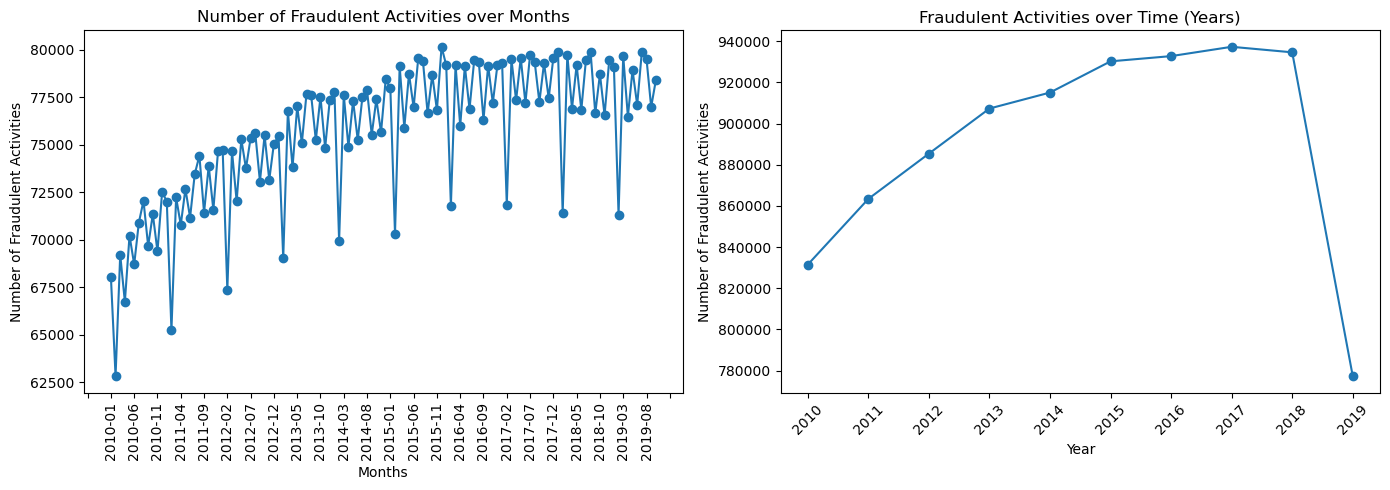

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

# Group number of fraud events per day, month, and year
tfmcu['date'] = tfmcu['date'].dt.date
tfmcu['month'] = pd.to_datetime(tfmcu['date']).dt.to_period('M')
tfmcu['year'] = pd.to_datetime(tfmcu['date']).dt.to_period('Y')

# Group by date, month, and year
tfmcu_day = tfmcu.groupby("date").size().reset_index(name="fraud count")
tfmcu_month = tfmcu.groupby("month").size().reset_index(name="fraud count")
tfmcu_year = tfmcu.groupby("year").size().reset_index(name="fraud count")

# Convert period to string for better plotting
tfmcu_month['month'] = tfmcu_month['month'].astype(str)
tfmcu_year['year'] = tfmcu_year['year'].astype(str)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Fraudulent activities over months
axes[0].plot(tfmcu_month['month'], tfmcu_month['fraud count'], marker='o', linestyle='-')
axes[0].set_title("Number of Fraudulent Activities over Months")
axes[0].set_xlabel("Months")
axes[0].set_ylabel("Number of Fraudulent Activities")
axes[0].tick_params(axis='x', rotation=90)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=30))

# Plot 2: Fraudulent activities over years
axes[1].plot(tfmcu_year['year'], tfmcu_year['fraud count'], marker='o', linestyle='-')
axes[1].set_title("Fraudulent Activities over Time (Years)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Fraudulent Activities")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


### Categorical Bar Plots

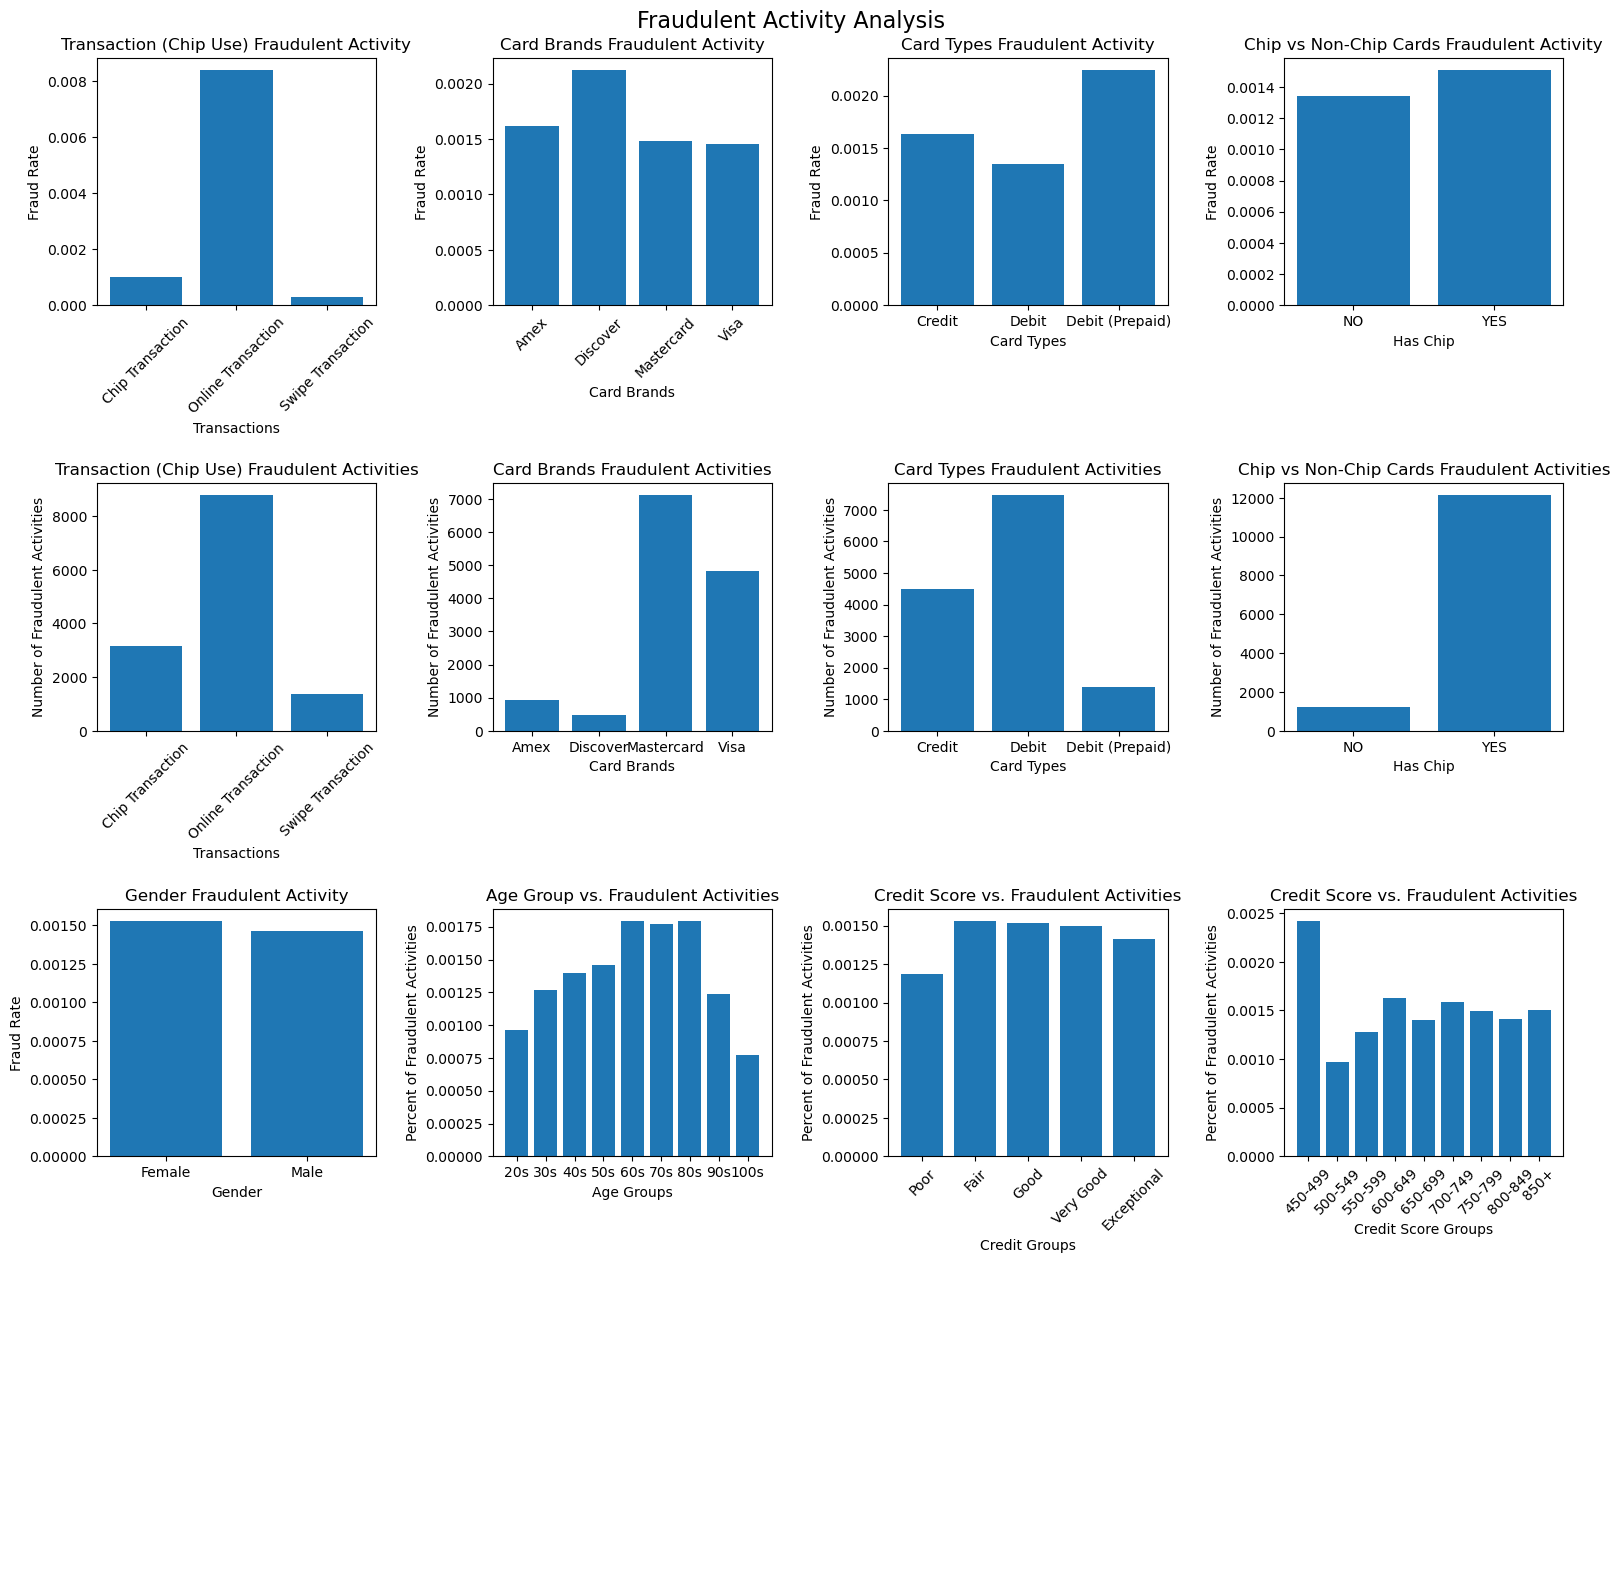

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # Adjust size as needed

# Transaction (Chip Use) Fraudulent Activity - Fraud Rate
axes[0, 0].bar(tfmcu.groupby("use_chip")["fraud_binary"].mean().index,
               tfmcu.groupby("use_chip")["fraud_binary"].mean())
axes[0, 0].set_xlabel('Transactions')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylabel('Fraud Rate')
axes[0, 0].set_title('Transaction (Chip Use) Fraudulent Activity')

# Card Brand Fraudulent Activity - Fraud Rate
axes[0, 1].bar(tfmcu.groupby("card_brand")["fraud_binary"].mean().index,
               tfmcu.groupby("card_brand")["fraud_binary"].mean())
axes[0, 1].set_xlabel('Card Brands')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylabel('Fraud Rate')
axes[0, 1].set_title('Card Brands Fraudulent Activity')

# Card Type Fraudulent Activity - Fraud Rate
axes[0, 2].bar(tfmcu.groupby("card_type")["fraud_binary"].mean().index,
               tfmcu.groupby("card_type")["fraud_binary"].mean())
axes[0, 2].set_xlabel('Card Types')
axes[0, 2].set_ylabel('Fraud Rate')
axes[0, 2].set_title('Card Types Fraudulent Activity')

# Has Chip Fraudulent Activity - Fraud Rate
axes[0, 3].bar(tfmcu.groupby("has_chip")["fraud_binary"].mean().index,
               tfmcu.groupby("has_chip")["fraud_binary"].mean())
axes[0, 3].set_xlabel('Has Chip')
axes[0, 3].set_ylabel('Fraud Rate')
axes[0, 3].set_title('Chip vs Non-Chip Cards Fraudulent Activity')

# Transaction (Chip Use) Fraudulent Activities - Number of Frauds
axes[1, 0].bar(tfmcu.groupby("use_chip")["fraud_binary"].sum().index,
               tfmcu.groupby("use_chip")["fraud_binary"].sum())
axes[1, 0].set_xlabel('Transactions')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylabel('Number of Fraudulent Activities')
axes[1, 0].set_title('Transaction (Chip Use) Fraudulent Activities')

# Card Brand Fraudulent Activities - Number of Frauds
axes[1, 1].bar(tfmcu.groupby("card_brand")["fraud_binary"].sum().index,
               tfmcu.groupby("card_brand")["fraud_binary"].sum())
axes[1, 1].set_xlabel('Card Brands')
axes[1, 1].set_ylabel('Number of Fraudulent Activities')
axes[1, 1].set_title('Card Brands Fraudulent Activities')

# Card Type Fraudulent Activities - Number of Frauds
axes[1, 2].bar(tfmcu.groupby("card_type")["fraud_binary"].sum().index,
               tfmcu.groupby("card_type")["fraud_binary"].sum())
axes[1, 2].set_xlabel('Card Types')
axes[1, 2].set_ylabel('Number of Fraudulent Activities')
axes[1, 2].set_title('Card Types Fraudulent Activities')

# Has Chip Fraudulent Activities - Number of Frauds
axes[1, 3].bar(tfmcu.groupby("has_chip")["fraud_binary"].sum().index,
               tfmcu.groupby("has_chip")["fraud_binary"].sum())
axes[1, 3].set_xlabel('Has Chip')
axes[1, 3].set_ylabel('Number of Fraudulent Activities')
axes[1, 3].set_title('Chip vs Non-Chip Cards Fraudulent Activities')

# Gender Fraudulent Activity - Fraud Rate
axes[2, 0].bar(tfmcu.groupby("gender")["fraud_binary"].mean().index,
               tfmcu.groupby("gender")["fraud_binary"].mean())
axes[2, 0].set_xlabel('Gender')
axes[2, 0].set_ylabel('Fraud Rate')
axes[2, 0].set_title('Gender Fraudulent Activity')

# Age Group Fraudulent Activity - Fraud Rate
age_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
age_labels = ['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
tfmcu["age_group"] = pd.cut(tfmcu["current_age"], bins=age_bins, labels=age_labels, right=False)
age_grouped = tfmcu.groupby("age_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 1].bar(age_grouped['age_group'], age_grouped['fraud_rate'])
axes[2, 1].set_xlabel('Age Groups')
axes[2, 1].set_ylabel('Percent of Fraudulent Activities')
axes[2, 1].set_title('Age Group vs. Fraudulent Activities')

# Credit Group Fraudulent Activity - Fraud Rate 
credit_bins = [300, 580, 670, 740, 800, 850]
credit_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']
tfmcu["credit_group"] = pd.cut(tfmcu["credit_score"], bins=credit_bins, labels=credit_labels, right=False)
credit_grouped = tfmcu.groupby("credit_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 2].bar(credit_grouped['credit_group'], credit_grouped['fraud_rate'])
axes[2, 2].set_xlabel('Credit Groups')
axes[2, 2].tick_params(axis='x', rotation=45)
axes[2, 2].set_ylabel('Percent of Fraudulent Activities')
axes[2, 2].set_title('Credit Score vs. Fraudulent Activities')

# Credit Score Group Fraudulent Activity - Fraud Rate 
credit_bins = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
credit_labels = ['450-499', '500-549', '550-599', '600-649', '650-699', '700-749', '750-799', '800-849', '850+']
tfmcu["credit_score_group"] = pd.cut(tfmcu["credit_score"], bins=credit_bins, labels=credit_labels, right=False)
credit_score_grouped = tfmcu.groupby("credit_score_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 3].bar(credit_score_grouped["credit_score_group"], credit_score_grouped['fraud_rate'])
axes[2, 3].set_xlabel('Credit Score Groups')
axes[2, 3].tick_params(axis='x', rotation=45)
axes[2, 3].set_ylabel('Percent of Fraudulent Activities')
axes[2, 3].set_title('Credit Score vs. Fraudulent Activities')

# Optional plots 
axes[3, 0].axis('off')
axes[3, 1].axis('off')
axes[3, 2].axis('off')
axes[3, 3].axis('off')

# Adjust layout and display
plt.tight_layout(pad=2.0)  # Adjust padding between subplots for better spacing
plt.suptitle('Fraudulent Activity Analysis', fontsize=16, y = 1)  # Set a main title for the entire figure
plt.show()

In [24]:
tfmcu.to_csv('output2.csv', index=False)

### Feature Engineering

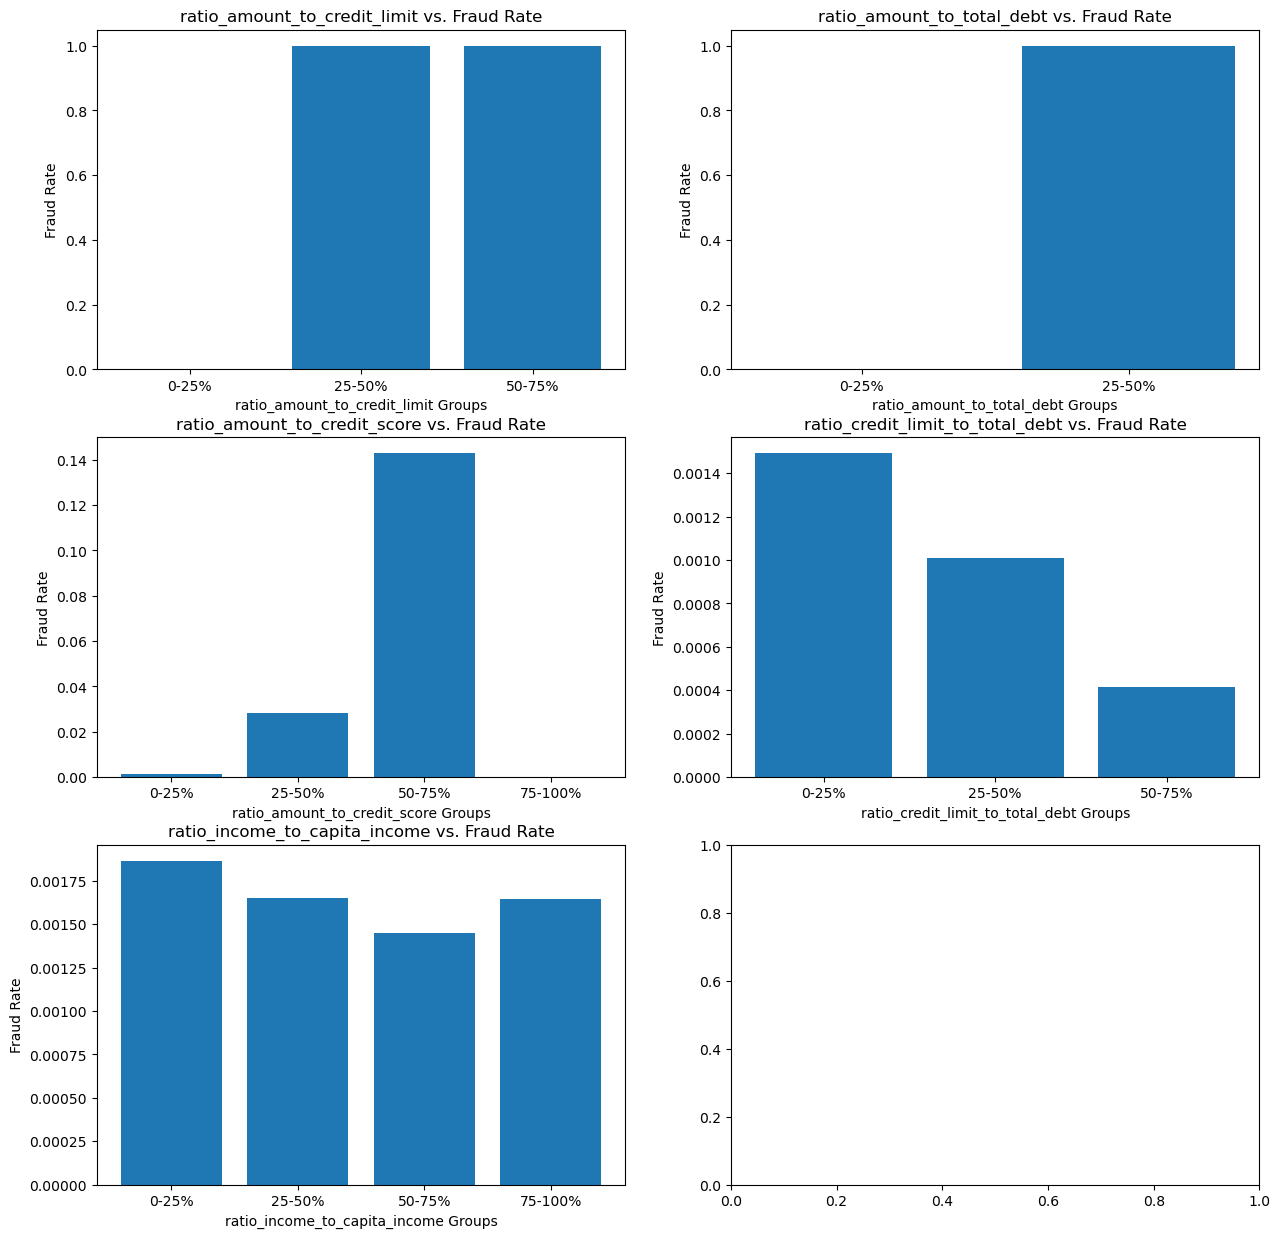

In [26]:
import matplotlib.pyplot as plt

ratio_columns = [
    "ratio_amount_to_credit_limit",
    "ratio_amount_to_total_debt",
    "ratio_amount_to_credit_score",
    "ratio_credit_limit_to_total_debt",
    "ratio_income_to_capita_income"
]

# Function to automate graph creation
def automate_graphs(data, ratio_columns):
    # Setting up the plot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Adjust grid size based on the number of plots
    axes = axes.flatten()  # Flatten for easy iteration

    for i, column in enumerate(ratio_columns):
        if i >= len(axes):  # Avoid errors if too many columns
            break

        # Calculate the min and max
        min_val = data[f'{column}'].min()
        max_val = data[f'{column}'].max()
        
        # Create 4 sections (quartiles)
        column_bins = [min_val, 
                min_val + (max_val - min_val) * 0.25, 
                min_val + (max_val - min_val) * 0.5, 
                min_val + (max_val - min_val) * 0.75, 
                max_val]
        
        # Generate the data for each column
        #column_bins = [0, 0.25, 0.5, 0.75, 1.0]  # Customize bin ranges if needed
        column_labels = ['0-25%', '25-50%', '50-75%', '75-100%']
        data[f"{column}_group"] = pd.cut(data[column], bins=column_bins, labels=column_labels, right=False)
        grouped_data = data.groupby(f"{column}_group",observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
        
        # Create the bar plot
        ax = axes[i]
        ax.bar(grouped_data[f"{column}_group"].astype(str), grouped_data["fraud_rate"])
        ax.set_xlabel(f'{column} Groups')
        ax.set_ylabel('Fraud Rate')
        ax.set_title(f'{column} vs. Fraud Rate')

# Usage
automate_graphs(tfmcu, ratio_columns)


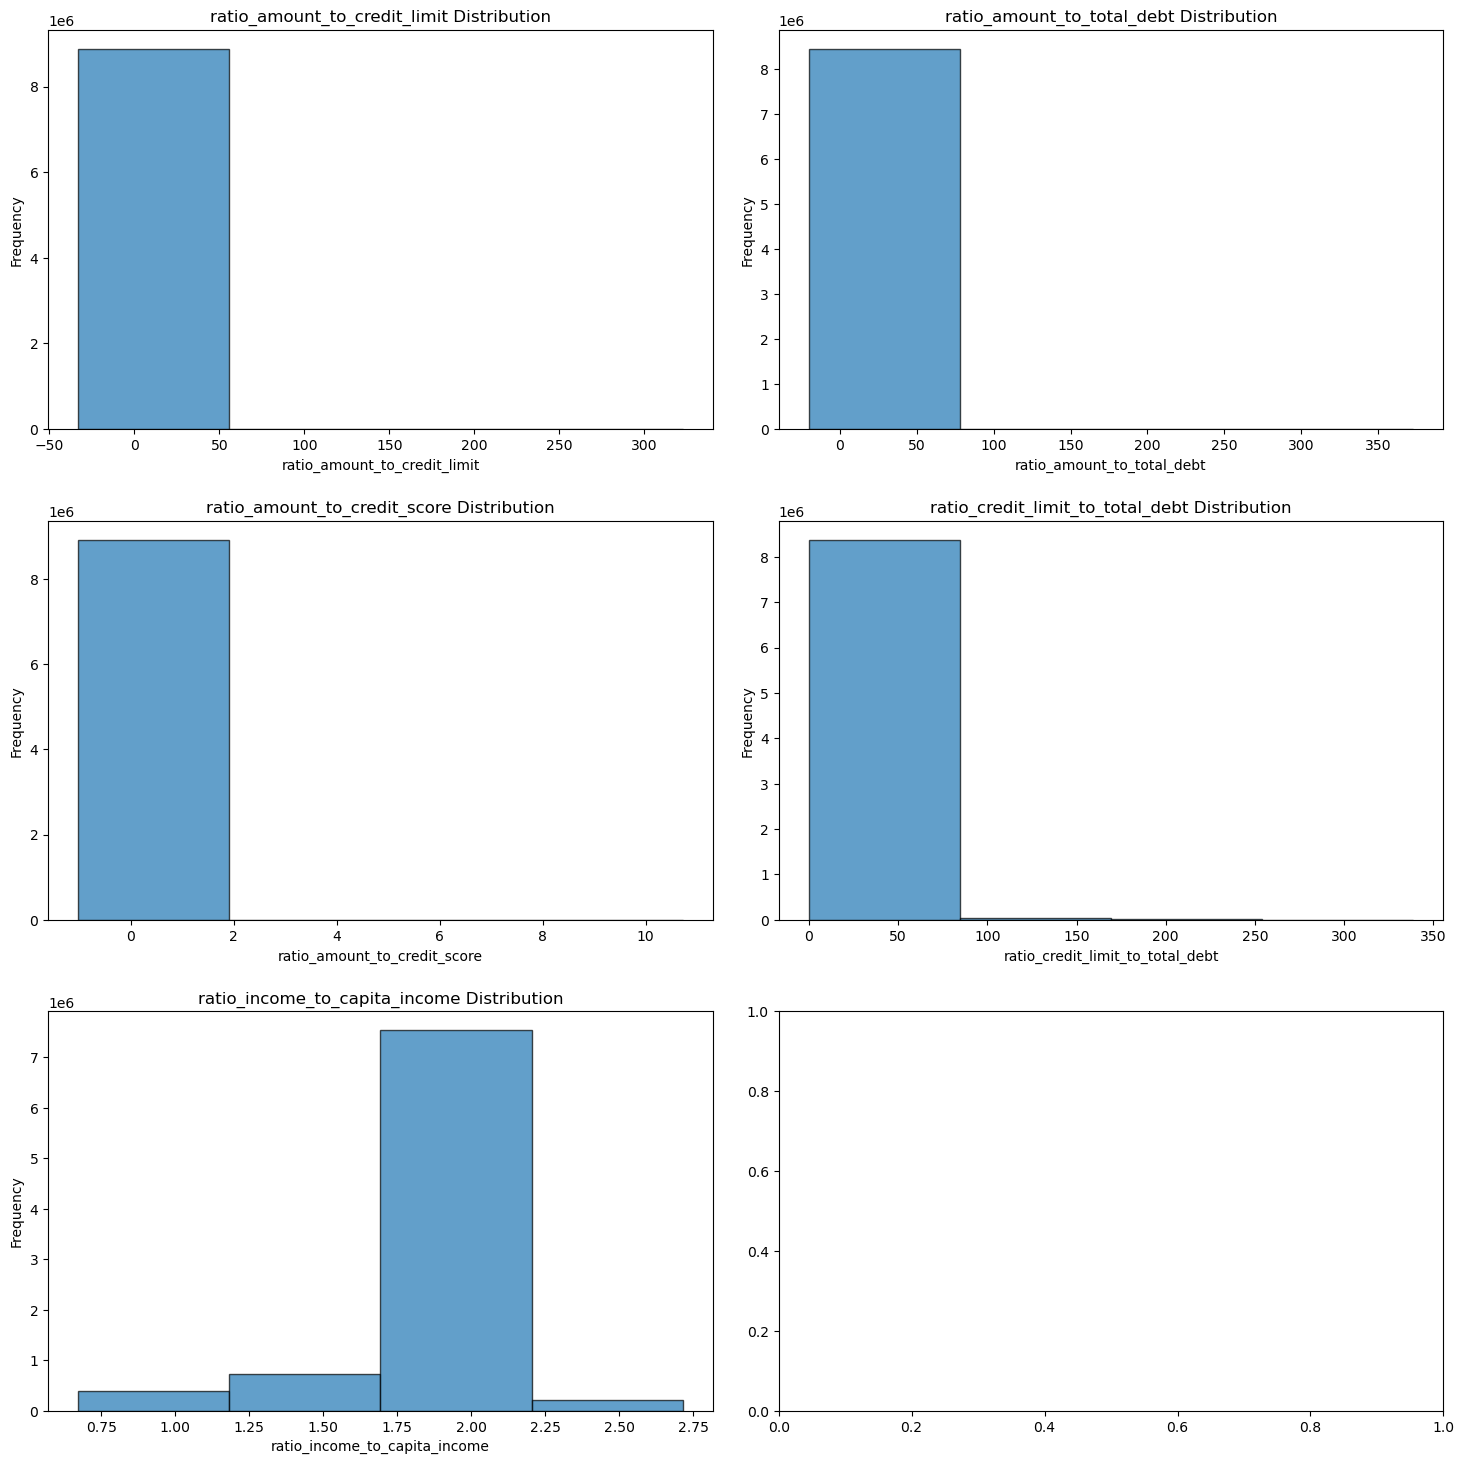

In [27]:
import matplotlib.pyplot as plt

ratio_columns = [
    "ratio_amount_to_credit_limit",
    "ratio_amount_to_total_debt",
    "ratio_amount_to_credit_score",
    "ratio_credit_limit_to_total_debt",
    "ratio_income_to_capita_income"
]

# Function to automate histogram creation
def automate_histograms(data, ratio_columns):
    # Setting up the plot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Adjust grid size based on the number of plots
    axes = axes.flatten()  # Flatten for easy iteration

    for i, column in enumerate(ratio_columns):
        if i >= len(axes):  # Avoid errors if too many columns
            break

        # Create the histogram for each ratio column
        ax = axes[i]
        ax.hist(data[column], bins=4, edgecolor='black', alpha=0.7)
        
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{column} Distribution')

    # Adjust layout for better spacing
    plt.tight_layout(pad=2.0)
    plt.show()

# Usage
automate_histograms(tfmcu, ratio_columns)


<Axes: xlabel='credit_group', ylabel='age_group'>

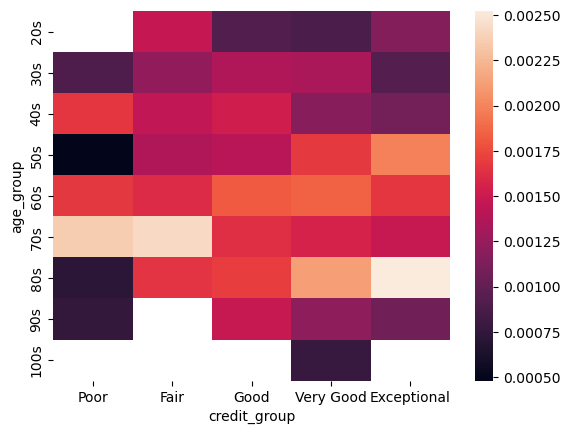

In [28]:
age_v_credit = pd.crosstab(tfmcu["age_group"],tfmcu["credit_group"], values = tfmcu["fraud_binary"],aggfunc = "mean")
sns.heatmap(age_v_credit)

In [29]:
#Correlation for subset of dataframe
corr = tfmcu_sub.corr(method = 'pearson')
corr

,amount,fraud_binary,has_chip_binary,num_cards_issued,credit_limit,year_pin_last_changed,current_age,retirement_age,gender_binary,per_capita_income,...,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,card_brand_Amex,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Credit,card_type_Debit,card_type_Debit (Prepaid)
amount,1.000000,0.031940,0.001276,-0.000289,0.068618,0.006759,-0.004277,-0.005131,-0.000699,0.103255,...,-0.019200,0.063717,-0.022578,0.038281,0.023299,-0.036041,0.010194,0.098277,-0.056714,-0.070768
fraud_binary,0.031940,1.000000,0.001301,-0.000108,-0.005706,0.000152,0.004423,0.000567,-0.000882,-0.002882,...,-0.009763,0.065160,-0.032572,0.000805,0.002630,-0.000365,-0.000885,0.002339,-0.004988,0.005285
has_chip_binary,0.001276,0.001301,1.000000,0.011237,-0.007638,0.016499,-0.010542,-0.000451,-0.014385,-0.020137,...,0.249730,0.013057,-0.248307,0.030331,-0.004340,-0.034428,0.021532,0.003645,-0.002245,-0.002354
num_cards_issued,-0.000289,-0.000108,0.011237,1.000000,-0.067989,0.041302,0.015334,-0.063372,-0.029945,0.010404,...,0.004112,-0.003926,-0.001423,-0.029903,-0.015571,-0.000673,0.020909,-0.031782,0.032125,-0.003516
credit_limit,0.068618,-0.005706,-0.007638,-0.067989,1.000000,-0.038900,-0.035974,0.014058,0.014343,0.608114,...,-0.000806,0.018105,-0.010892,-0.073951,-0.044330,0.029356,0.021286,-0.193059,0.366037,-0.348013
year_pin_last_changed,0.006759,0.000152,0.016499,0.041302,-0.038900,1.000000,-0.030288,0.006921,-0.046884,0.002680,...,0.069936,-0.006036,-0.063298,0.011905,-0.018752,0.020623,-0.021215,0.020447,-0.018329,-0.002217
current_age,-0.004277,0.004423,-0.010542,0.015334,-0.035974,-0.030288,1.000000,-0.008016,-0.040282,0.010588,...,-0.017779,0.005964,0.013240,-0.029858,0.021116,-0.013277,0.021974,-0.011265,0.002395,0.015975
retirement_age,-0.005131,0.000567,-0.000451,-0.063372,0.014058,0.006921,-0.008016,1.000000,0.038112,-0.041218,...,0.004538,0.001770,-0.005498,0.005170,0.010441,-0.049238,0.044762,0.075084,-0.064623,-0.013280
gender_binary,-0.000699,-0.000882,-0.014385,-0.029945,0.014343,-0.046884,-0.040282,0.038112,1.000000,-0.034312,...,-0.007474,-0.009869,0.013534,-0.013182,0.001022,-0.013077,0.019836,-0.000712,0.000636,0.000082
per_capita_income,0.103255,-0.002882,-0.020137,0.010404,0.608114,0.002680,0.010588,-0.041218,-0.034312,1.000000,...,-0.013332,0.027025,-0.004617,-0.002416,-0.009996,-0.013054,0.017906,-0.017664,0.026381,-0.018313


## Step 3.5: Modeling (Decision Tree, Logistic Regression, Random Forest)

In [31]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def balance_dataset(data, target_column, method='undersample', random_state=42):
    """
    Balance a dataset using undersampling or oversampling.
    
    Parameters:
        data (pd.DataFrame): The dataset to balance.
        target_column (str): The name of the target column.
        method (str): 'undersample', 'oversample', or 'smote'.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        pd.DataFrame: A balanced dataset.
    """
    X = data.drop(columns=[target_column])  # Features
    y = data[target_column]  # Target
    
    if method == 'undersample':
        # Using RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X, y)
        
    elif method == 'oversample':
        # Using RandomOverSampler
        ros = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = ros.fit_resample(X, y)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    
    else:
        raise ValueError("Method must be 'undersample', 'oversample', or 'smote'.")
    
    # Combine resampled features and target into a single DataFrame
    balanced_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=[target_column])], axis=1)
    return balanced_data


In [32]:
#Create Balance dataset 
balanced_data = balance_dataset(tfmcu_sub, target_column='fraud_binary', method='undersample')
print(balanced_data['fraud_binary'].value_counts())

fraud_binary
0    13332
1    13332
Name: count, dtype: int64


### Decision Tree - Training and Testing

#### Training 

Accuracy: 0.998553702284079
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2516488
           1       0.90      0.03      0.06      3740

    accuracy                           1.00   2520228
   macro avg       0.95      0.51      0.53   2520228
weighted avg       1.00      1.00      1.00   2520228



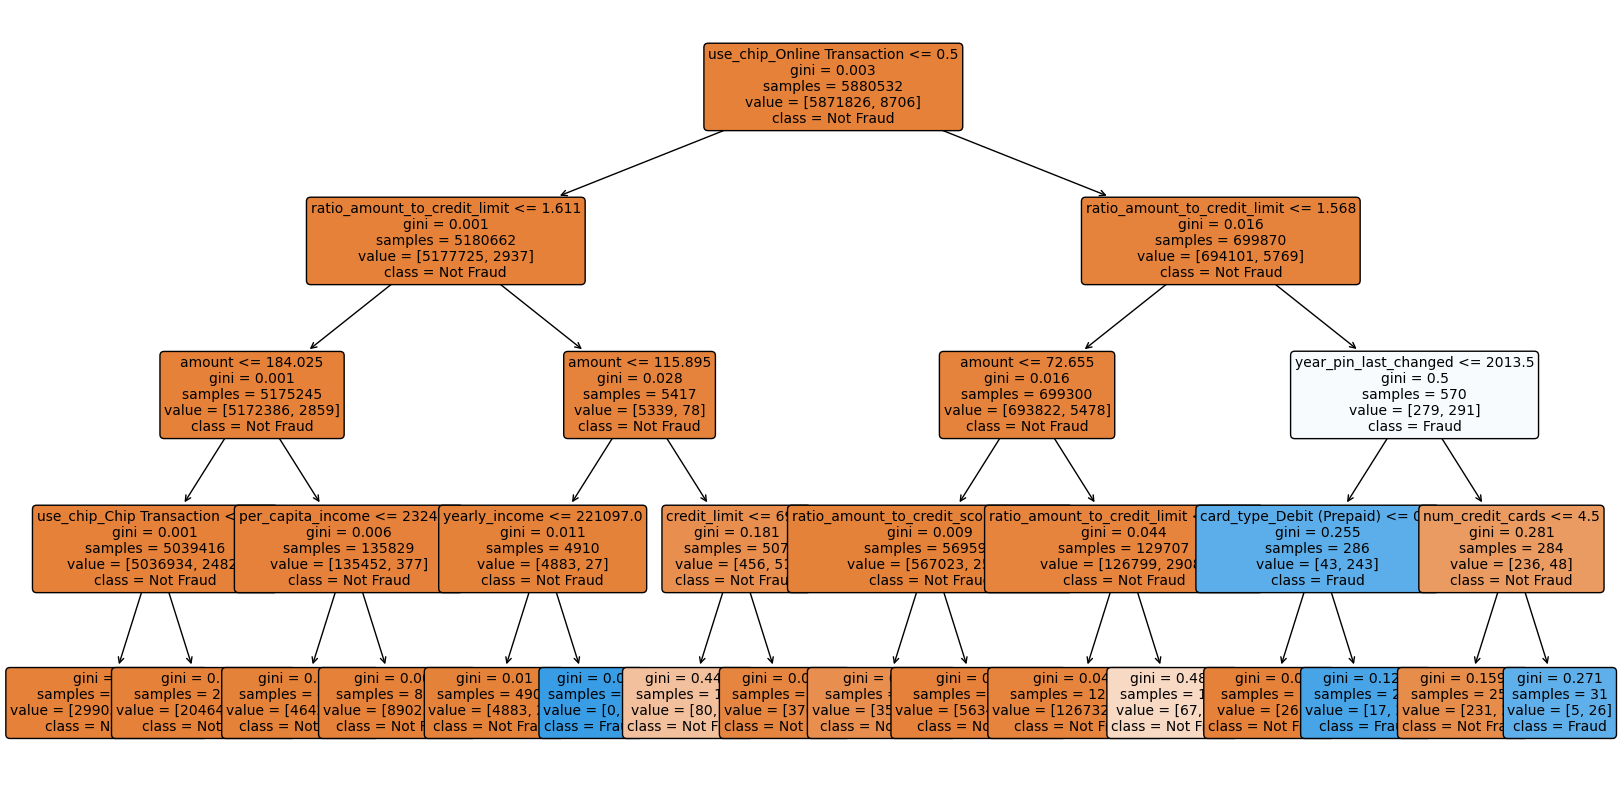

In [85]:
## Running the model with low depth to see if there are any defining characteristics that are easily identified

# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

balanced = False 
if balanced:    
    # Step 2: Load your dataset - 'fraud_binary' is the target variable and other columns are features
    X = balanced_data.drop(columns=["fraud_binary"])  # Feature columns
    y = balanced_data["fraud_binary"]  # Target column (fraud binary)
else:
    X = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
    y = tfmcu_sub["fraud_binary"]

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create and train the Decision Tree model
clf = DecisionTreeClassifier(max_depth = 4, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Visualize the Decision Tree
plt.figure(figsize=(20, 10))  # Increase the figure size for better visibility
plot_tree(
    clf, 
    feature_names=X_train.columns,  # Replace with your feature names
    class_names=["Not Fraud", "Fraud"],  # Replace with your class names
    filled=True, 
    rounded=True, 
    fontsize=10  # Adjust font size for readability
)
plt.show()

In [69]:
### Iterate through different depths to find best recall and precision and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1: Define a range of depths to test
depth_range = range(1, 100)  # Adjust range as needed
precision_scores = []
recall_scores = []
f1_scores = []

# Step 2: Iterate over each depth
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    
    # Step 3: Make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Step 4: Calculate precision, recall, and f1-score and store them
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    precision_scores.append((depth, precision))
    recall_scores.append((depth, recall))
    f1_scores.append((depth, f1))

# Step 5: Find the depth with the highest precision, highest recall, and highest F1-score
best_depth_precision, best_precision = max(precision_scores, key=lambda x: x[1])
print(f"Best Depth for Precision: {best_depth_precision}, Best Precision: {best_precision}")

best_depth_recall, best_recall = max(recall_scores, key=lambda x: x[1])
print(f"Best Depth for Recall: {best_depth_recall}, Best Recall: {best_recall}")

best_depth_f1, best_f1 = max(f1_scores, key=lambda x: x[1])
print(f"Best Depth for F1 Score: {best_depth_f1}, Best F1 Score: {best_f1}")

KeyboardInterrupt: 

#### Testing the model on full dataset

In [38]:
## Use highest precision depth to create and train the Decision Tree model
clf = DecisionTreeClassifier(max_depth = best_depth_precision, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
X_tfmcu = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
y_tfmcu = tfmcu_sub["fraud_binary"]  # Target column (fraud binary)
y_tfmcu_pred = clf.predict(X_tfmcu)
print("Accuracy:", accuracy_score(y_tfmcu, y_tfmcu_pred))
print("Classification Report:\n", classification_report(y_tfmcu, y_tfmcu_pred))


Accuracy: 0.8833703516212014
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94   8901631
           1       0.01      0.66      0.02     13332

    accuracy                           0.88   8914963
   macro avg       0.50      0.77      0.48   8914963
weighted avg       1.00      0.88      0.94   8914963



In [39]:
## Use highest recall depth to create and train the Decision Tree model
clf = DecisionTreeClassifier(max_depth = best_depth_recall, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
X_tfmcu = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
y_tfmcu = tfmcu_sub["fraud_binary"]  # Target column (fraud binary)
y_tfmcu_pred = clf.predict(X_tfmcu)
print("Accuracy:", accuracy_score(y_tfmcu, y_tfmcu_pred))
print("Classification Report:\n", classification_report(y_tfmcu, y_tfmcu_pred))

Accuracy: 0.8046279047933234
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89   8901631
           1       0.01      0.91      0.01     13332

    accuracy                           0.80   8914963
   macro avg       0.50      0.86      0.45   8914963
weighted avg       1.00      0.80      0.89   8914963



In [73]:
## Use highest F1-score depth to create and train the Decision Tree model
clf = DecisionTreeClassifier(max_depth = best_depth_f1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
X_tfmcu = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
y_tfmcu = tfmcu_sub["fraud_binary"]  # Target column (fraud binary)
y_tfmcu_pred = clf.predict(X_tfmcu)
print("Accuracy:", accuracy_score(y_tfmcu, y_tfmcu_pred))
print("Classification Report:\n", classification_report(y_tfmcu, y_tfmcu_pred))

Accuracy: 0.8078420285783667
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89   8388314
           1       0.01      0.91      0.01     12446

    accuracy                           0.81   8400760
   macro avg       0.50      0.86      0.45   8400760
weighted avg       1.00      0.81      0.89   8400760



In [81]:
pd.Series(y_tfmcu_pred).describe()
y_tfmcu_pred.sum()

1624409

Notes: 

Due to high imbalance in the dataset between fraud (1) and not fraud (0), precision is difficult to predict since the model will end up predicting almost all instances as not fraud (0) since it avoids predicting the rare class. Consequently, True Positives (TP) are very low to zero, leading the precision to be 0. 

### Logistic Regression

#### Training

In [62]:
## Logistic regression 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## creating a smaller subset to help converge logistic regression (Keeping most of the numeric columns from the original dataset)
tfmcu_subset = tfmcu[['amount',
       'fraud_binary', 'has_chip_binary',
       'num_cards_issued', 'credit_limit',
       'year_pin_last_changed', 'current_age',
       'retirement_age', 'gender_binary', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards',
       'ratio_amount_to_credit_limit', 'ratio_amount_to_total_debt',
       'ratio_amount_to_credit_score', 'ratio_credit_limit_to_total_debt',
       'ratio_income_to_capita_income'
       ]]

balanced = balance_dataset(tfmcu_subset, target_column='fraud_binary', method='undersample')
print(balanced['fraud_binary'].value_counts())

balanced = balanced.dropna()
X = balanced.drop('fraud_binary', axis=1)  # Drop the target column to get the features
y = balanced['fraud_binary']  # The target column (binary 0 or 1)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Only transform the test data (to prevent data leakage)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],  # l1 is less stable for logistic regression
    'solver': ['lbfgs', 'liblinear'],  # lbfgs works well for large datasets
}

grid_search = GridSearchCV(LogisticRegression(max_iter=10000, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train using the best found parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)
y_pred = best_log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{report}')
print(f'Confusion Matrix: \n{conf_matrix}')

fraud_binary
0    13332
1    13332
Name: count, dtype: int64
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.6471648968142657
Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      2554
           1       0.66      0.57      0.61      2437

    accuracy                           0.65      4991
   macro avg       0.65      0.65      0.64      4991
weighted avg       0.65      0.65      0.65      4991

Confusion Matrix: 
[[1841  713]
 [1048 1389]]


#### Testing

In [65]:
## Use highest F1-score depth to create and train the Decision Tree model
tfmcu_subset = tfmcu_subset.dropna()
X_tfmcu = tfmcu_subset.drop(columns=["fraud_binary"])  # Feature columns
y_tfmcu = tfmcu_subset["fraud_binary"]  # Target column (fraud binary)
y_tfmcu_pred = best_log_reg.predict(X_tfmcu)
print("Accuracy:", accuracy_score(y_tfmcu, y_tfmcu_pred))
print("Classification Report:\n", classification_report(y_tfmcu, y_tfmcu_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy: 0.9627659878391955
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   8388314
           1       0.00      0.06      0.00     12446

    accuracy                           0.96   8400760
   macro avg       0.50      0.51      0.49   8400760
weighted avg       1.00      0.96      0.98   8400760



### Random Forest

#### Training

In [89]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming you have a balanced dataset 'balanced' with features (X) and target (y)
X = tfmcu_sub.drop('fraud_binary', axis=1)  # Drop the target column to get the features
y = tfmcu_sub['fraud_binary']  # The target column (binary 0 or 1)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth = 10, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test)

# Calculate precision and recall
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Print precision and recall
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')

# Print detailed classification report
report = classification_report(y_test, y_pred_rf)
print(f'Classification Report: \n{report}')

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(f'Confusion Matrix: \n{conf_matrix}')


Precision: 0.9607843137254902
Recall: 0.03983739837398374
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1677692
           1       0.96      0.04      0.08      2460

    accuracy                           1.00   1680152
   macro avg       0.98      0.52      0.54   1680152
weighted avg       1.00      1.00      1.00   1680152

Confusion Matrix: 
[[1677688       4]
 [   2362      98]]


#### Testing

In [51]:
X_tfmcu = tfmcu_sub.drop(columns=["fraud_binary"])  # Feature columns
y_tfmcu = tfmcu_sub["fraud_binary"]  # Target column (fraud binary)
y_tfmcu_pred = rf_clf.predict(X_tfmcu)
print("Accuracy:", accuracy_score(y_tfmcu, y_tfmcu_pred))
print("Classification Report:\n", classification_report(y_tfmcu, y_tfmcu_pred))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- card_brand_Amex
- card_brand_Discover
- card_brand_Mastercard
- card_brand_Visa
- card_type_Credit
- ...


## Step 4: Analysis Insights

TBD